# 1) Importing libraries 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')
import dask.dataframe as dd
import missingno as msno
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold

In [2]:
np.random.seed(51)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2) Reading train_metadata_kaggle & test_metadata_kaggle

In [4]:
%%time
train_metadata_kaggle = dd.read_csv('klm_train.csv')
test_metadata_kaggle = dd.read_csv('klm_test.csv')
train_metadata_kaggle = train_metadata_kaggle.compute()
test_metadata_kaggle = test_metadata_kaggle.compute()
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 64) (3492890, 63)
CPU times: user 1min 37s, sys: 5.98 s, total: 1min 43s
Wall time: 17.6 s


In [5]:
test_id = test_metadata_kaggle['object_id']

In [6]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 64) (3492890, 63)


In [8]:
test_metadata_kaggle.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,flux__length,flux__longest_strike_above_mean,flux__longest_strike_below_mean,flux__mean_abs_change,flux__mean_change,flux_by_flux_ratio_sq__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_below_mean,mjd__mean_abs_change,mjd__mean_change,mjd_diff_det,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,haversine,latlon1,hostgal_photoz_certain
0,13,-12.680235,42.765503,3.997127,0.616561,9.149645,2.037355,0.691634,11.257108,2.461810,1.972973,1.718101,1.826388,0.157576,7806.412424,4.771625,1.896346e+05,5.396523,24.292155,55.445738,13.871398,2.282455,29.002872,37.684425,-0.247160,0.147622,92.039690,79.990817,10.567412,3.117684,164.640622,139.733762,4.512783,2.171455,300.547278,246.788411,2.951479,1.806797,408.305525,349.008202,0.094963,1.153076,324.515880,251.116361,0.072799,0.804929,330.0,15.0,32.0,4.426774,0.017885,9.0,222.0,2.350061,2.350061,119.8531,0.3193,0.0542,41.1123,0.019,1.851382,3.049709,0.337084
1,14,-11.142164,14.839427,0.884047,0.072856,3.399946,0.970525,0.690589,11.249375,2.457580,1.973559,1.717591,1.826703,0.012121,806.406927,11.486148,5.525817e+03,12.348124,6.852393,25.981591,29.389389,3.791608,22.708482,26.159787,0.099267,0.502325,13.685195,27.630359,13.429229,3.109318,31.012899,33.427074,13.769006,3.247873,56.042403,59.784625,1.750840,1.082798,83.561278,77.494564,-0.322108,-0.099957,84.725142,27.013154,-0.348744,0.132025,330.0,10.0,15.0,3.055953,-0.025935,4.0,85.0,9.335100,9.335100,28.0053,0.6323,0.0179,42.8774,0.018,1.855173,3.009107,0.643720
2,17,-14.202744,16.761280,0.791032,0.458390,3.886578,0.377131,0.663680,11.278636,2.702947,2.184483,1.922641,1.802497,0.014205,784.835502,9.509911,4.124400e+03,9.923556,5.255113,30.964024,39.143819,5.892170,6.030862,46.450439,0.590786,-0.427429,53.366119,41.192678,4.127763,1.710048,58.607170,42.353288,8.642889,2.570936,26.975615,59.958041,3.484929,1.141959,57.222812,72.448018,2.085327,0.429582,76.240782,73.533783,0.063837,-0.175525,352.0,15.0,15.0,3.247664,0.024840,4.0,75.0,0.690700,0.690700,2.7628,0.8297,0.0605,43.6000,0.016,0.309914,-1.490290,0.881446
3,23,-12.631923,28.061138,0.970396,0.465986,4.100713,2.177402,0.697639,11.305429,2.480364,2.003704,1.723367,1.821626,0.018182,876.027511,8.010597,8.293673e+03,9.227223,9.467365,40.693061,41.934474,4.298245,0.776942,14.926490,-0.580529,-0.058688,2.371129,22.476077,1.429683,-0.000571,34.447730,14.240274,1.223998,0.468594,58.911457,62.709899,4.269139,1.414380,115.918277,70.371095,7.377841,2.409871,112.547521,123.413344,1.793238,0.953107,330.0,10.0,12.0,3.299337,-0.001116,4.0,98.0,0.602500,0.602500,3.0125,0.6533,0.1479,42.9640,0.023,1.845038,3.078301,0.757434
4,34,-13.239577,124.475609,4.580070,0.301366,19.862714,4.537527,0.679312,11.365292,2.746784,2.210577,1.930790,1.798629,0.065341,47612.580669,9.140568,4.815012e+06,10.251332,101.128982,137.715186,30.068359,1.361778,65.064185,55.191226,7.457425,2.135457,202.641918,191.410916,16.393710,4.133929,425.940451,414.455381,15.206929,4.036551,368.228927,360.630612,15.386561,4.030676,377.744797,301.983950,15.302549,3.992

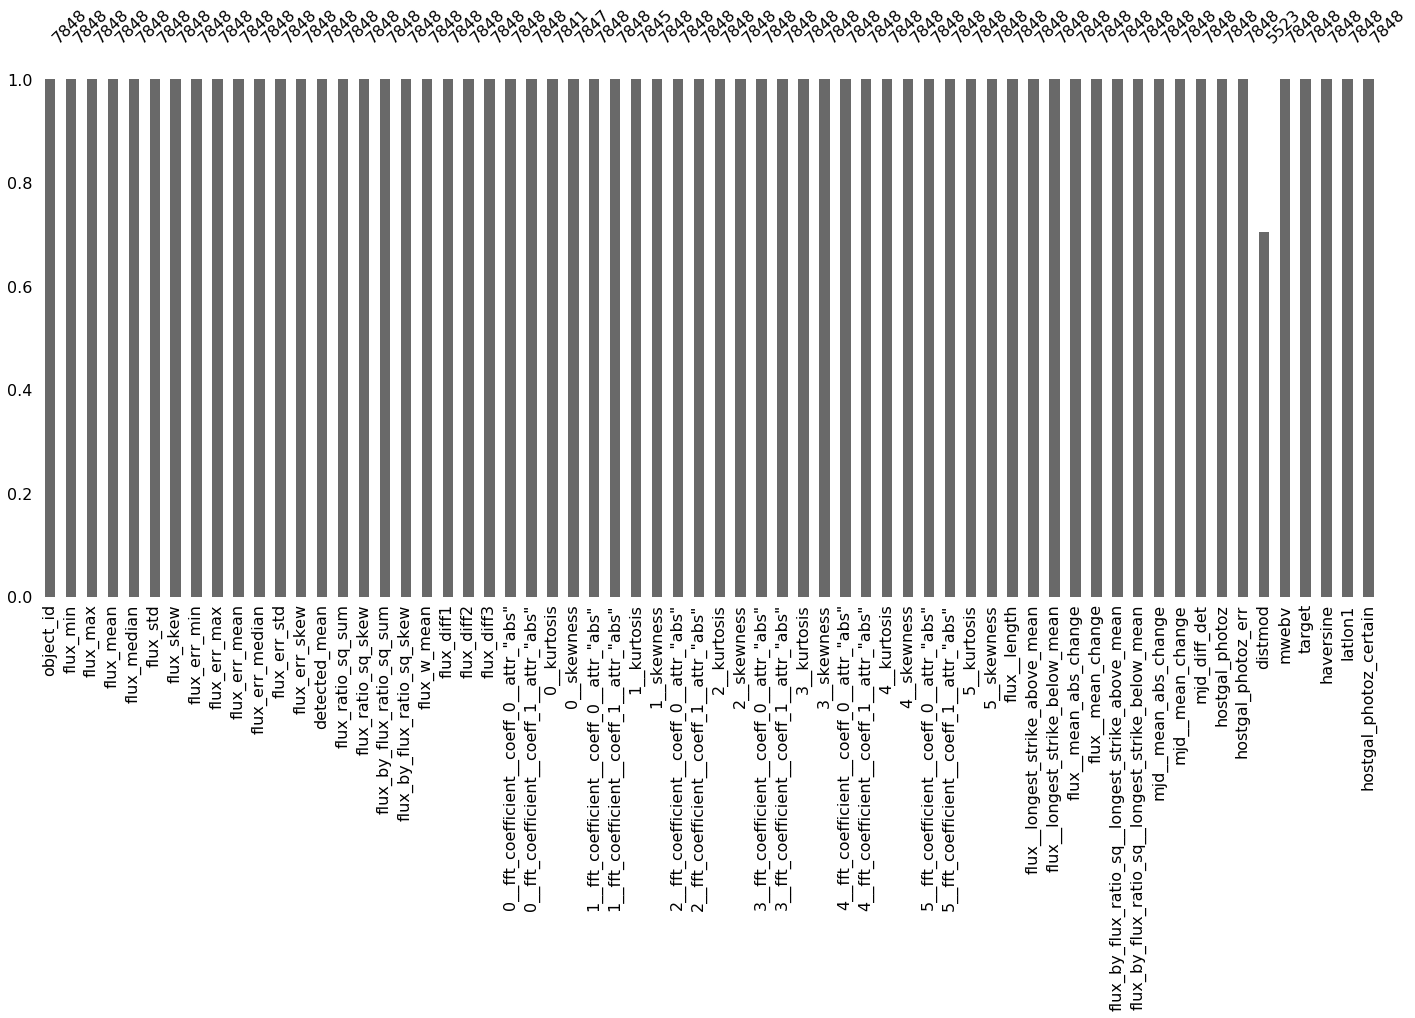

In [9]:
msno.bar(train_metadata_kaggle)

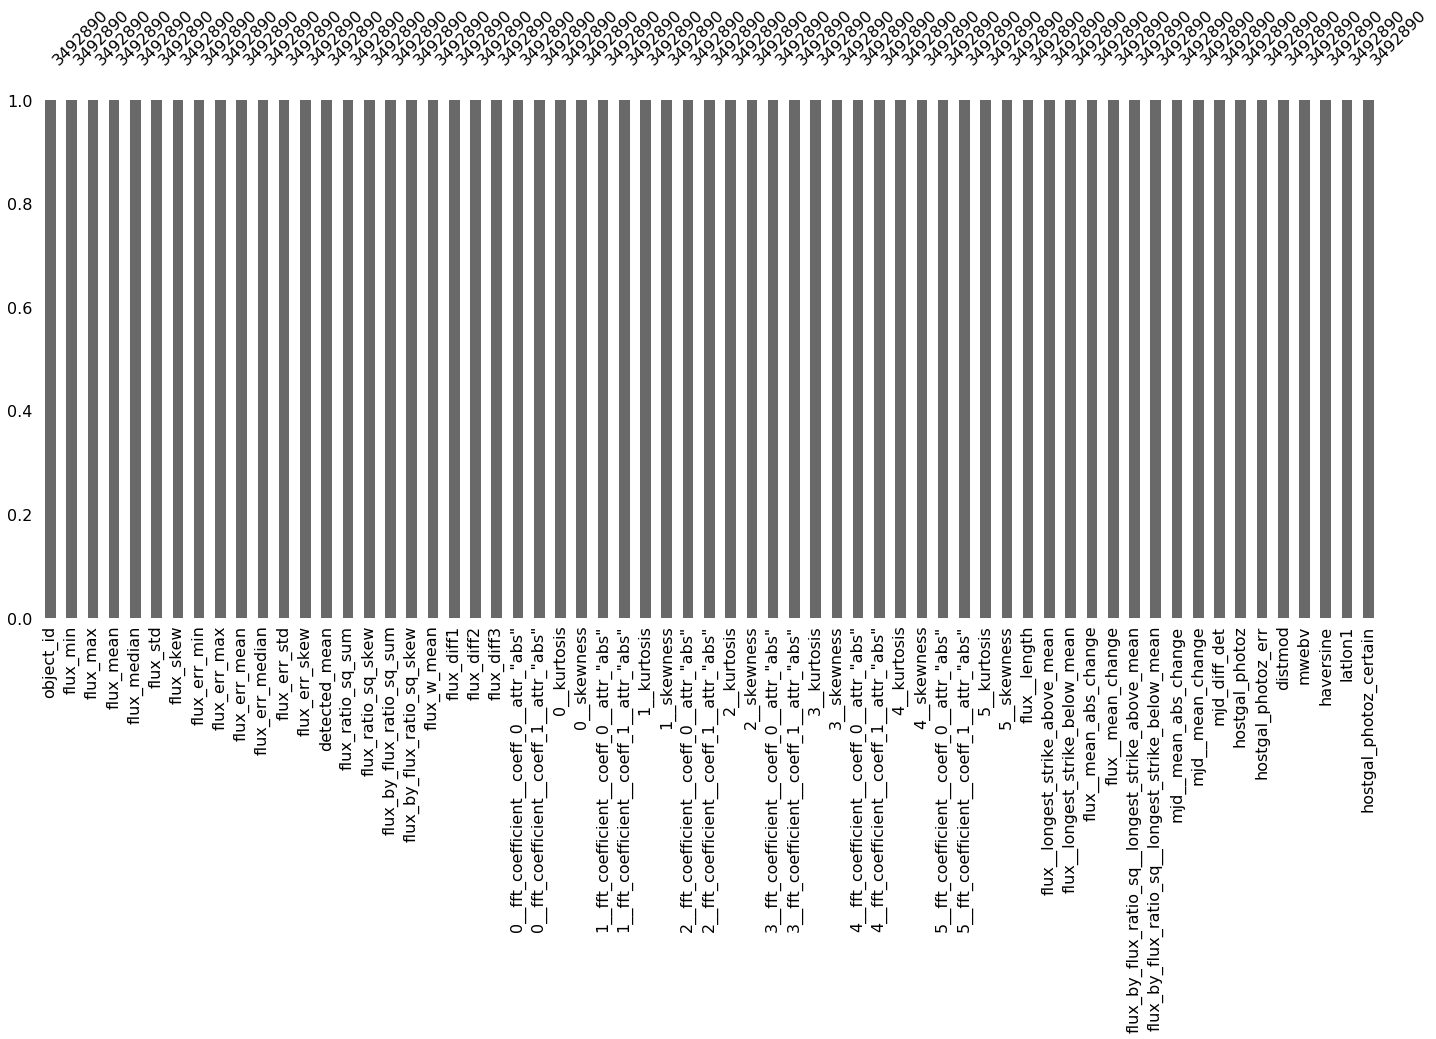

In [10]:
msno.bar(test_metadata_kaggle)

# 3) reading train_metadata_final & test_metadata_final

In [11]:
%%time
train_metadata = dd.read_csv('train_metadata_final.csv')
test_metadata = dd.read_csv('test_metadata_final.csv')
train_metadata = train_metadata.compute()
test_metadata = test_metadata.compute()
print(train_metadata.shape,test_metadata.shape)

(7848, 233) (3492890, 232)
CPU times: user 3min 47s, sys: 13.2 s, total: 4min
Wall time: 43.9 s


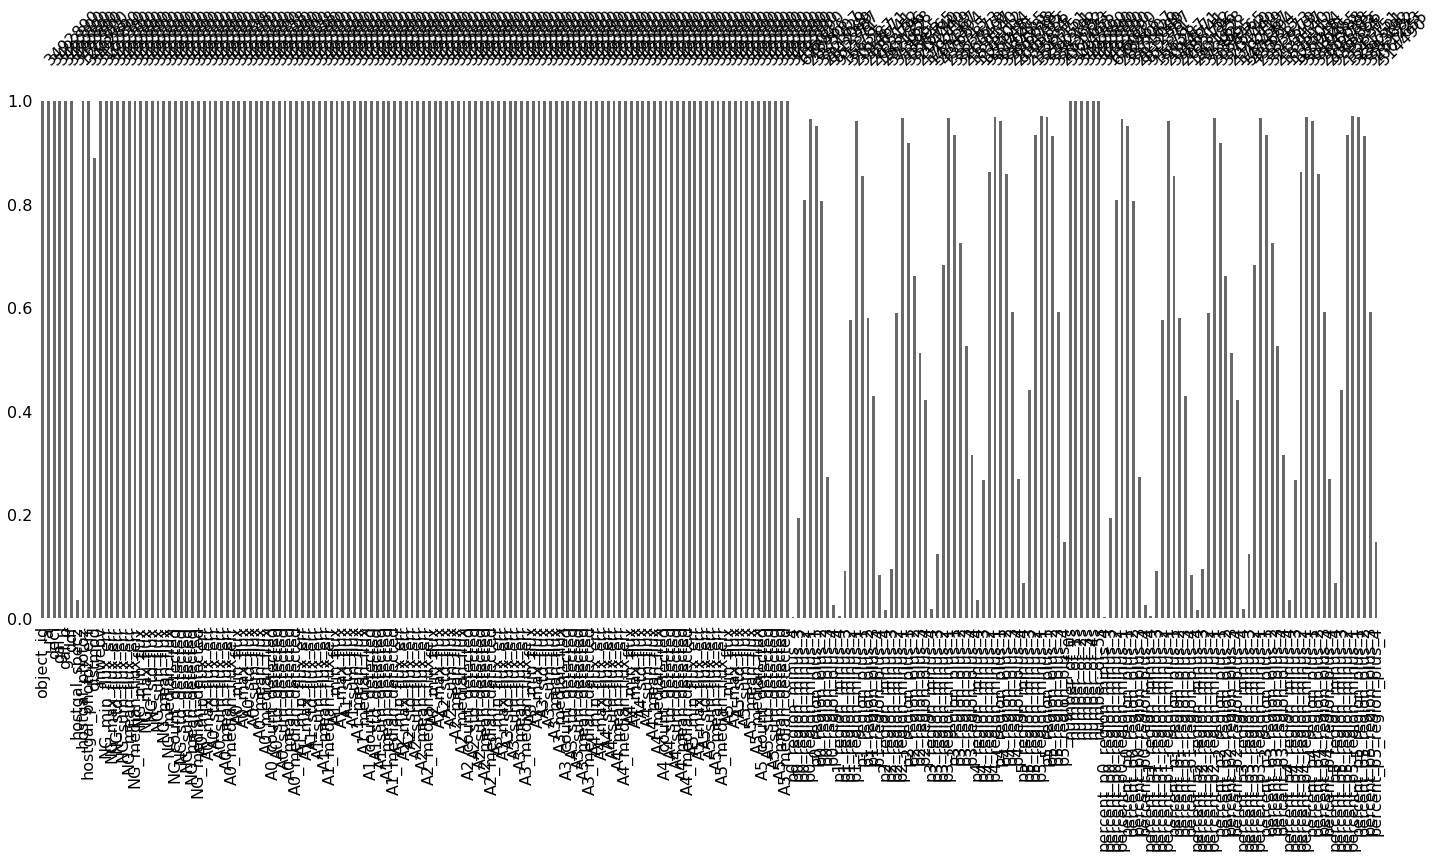

In [13]:
msno.bar(test_metadata)

In [14]:
columns_from_my_data = ['object_id','A0_sum_flux', 'A0_mean_flux', 'A0_std_detected', 'A1_mean_detected', 'A2_sum_detected', 'A4_mean_detected',
 'A5_std_detected', 'A5_mean_detected', 'percent_p2_region_minus_1', 'A2_min_flux', 'A5_sum_detected']

In [15]:
%%time
train_metadata_kaggle = train_metadata_kaggle.merge(right =train_metadata[columns_from_my_data],how = 'left',on = 'object_id')
test_metadata_kaggle = test_metadata_kaggle.merge(right =test_metadata[columns_from_my_data],how = 'left',on = 'object_id')

CPU times: user 1.63 s, sys: 1.05 s, total: 2.68 s
Wall time: 2.68 s


In [16]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 75) (3492890, 74)


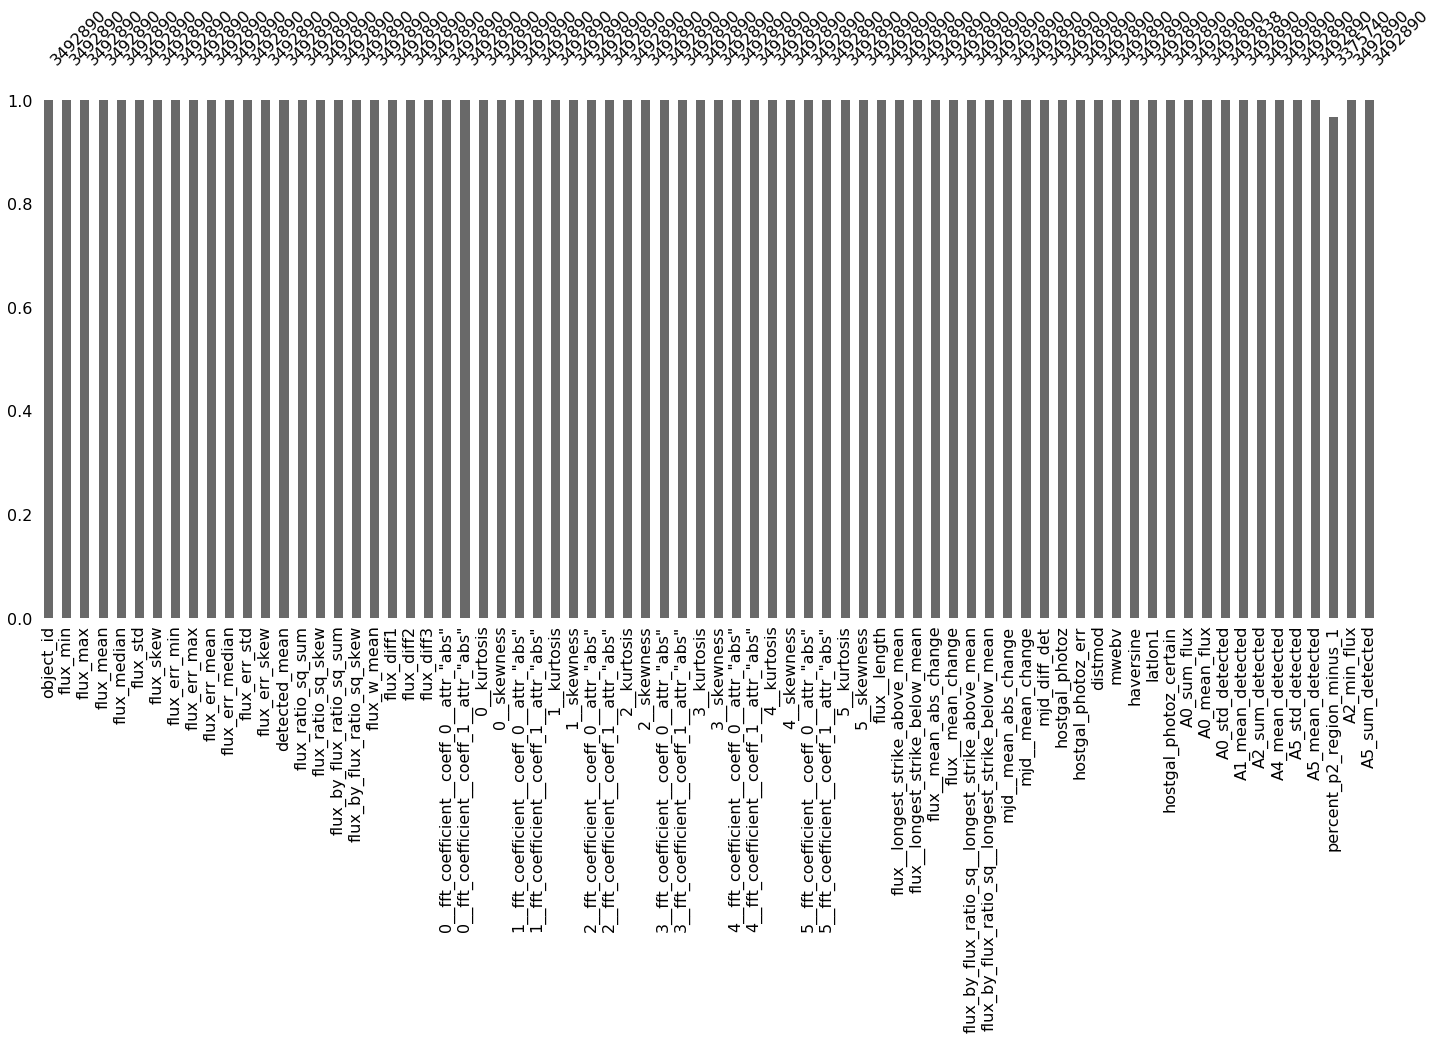

In [17]:
msno.bar(test_metadata_kaggle)

In [18]:
%%time
train_metadata = dd.read_csv('cesium_train.csv')
test_metadata = dd.read_csv('cesium_test.csv')
train_metadata = train_metadata.compute()
test_metadata = test_metadata.compute()
print(train_metadata.shape,test_metadata.shape)

(7848, 288) (3492890, 283)
CPU times: user 4min 51s, sys: 17.3 s, total: 5min 8s
Wall time: 57 s


In [19]:
test_metadata.columns = [x.replace("('","__").replace("',","___").replace(")","_").replace(' ','') for x in test_metadata.columns]

In [20]:
drop_from_train_metadata = [x for x in train_metadata.columns if x not in test_metadata.columns]

In [21]:
%%time
train_metadata.drop(drop_from_train_metadata,axis=1,inplace=True)
#test_metadata.drop(drop_from_train_metadata,axis=1,inplace=True)

CPU times: user 3.68 ms, sys: 0 ns, total: 3.68 ms
Wall time: 3.47 ms


In [22]:
print(train_metadata.shape,test_metadata.shape)

(7848, 283) (3492890, 283)


In [23]:
columns_from_cesium = ['object_id','__flux_percentile_ratio_mid50___5_', '__flux_percentile_ratio_mid65___2_', '__median_absolute_deviation___2_',
  '__qso_log_chi2_qsonu___0_', '__stetson_k___1_', '__freq1_signif___2_', '__stetson_k___2_', '__freq3_amplitude1___1_',
   '__median_absolute_deviation___2_', '__percent_close_to_median___2_',
   '__freq_varrat___5_','__freq_varrat___4_','__qso_log_chi2_qsonu___3_','__qso_log_chi2_qsonu___1_',
'__qso_log_chi2_qsonu___5_','__std___4_', '__freq_varrat___3_','__amplitude___2_']

In [24]:
%%time
train_metadata_kaggle = train_metadata_kaggle.merge(right =train_metadata[columns_from_cesium],how = 'left',on = 'object_id')
test_metadata_kaggle = test_metadata_kaggle.merge(right =test_metadata[columns_from_cesium],how = 'left',on = 'object_id')

CPU times: user 1.81 s, sys: 1.42 s, total: 3.23 s
Wall time: 3.22 s


In [25]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 93) (3492890, 92)


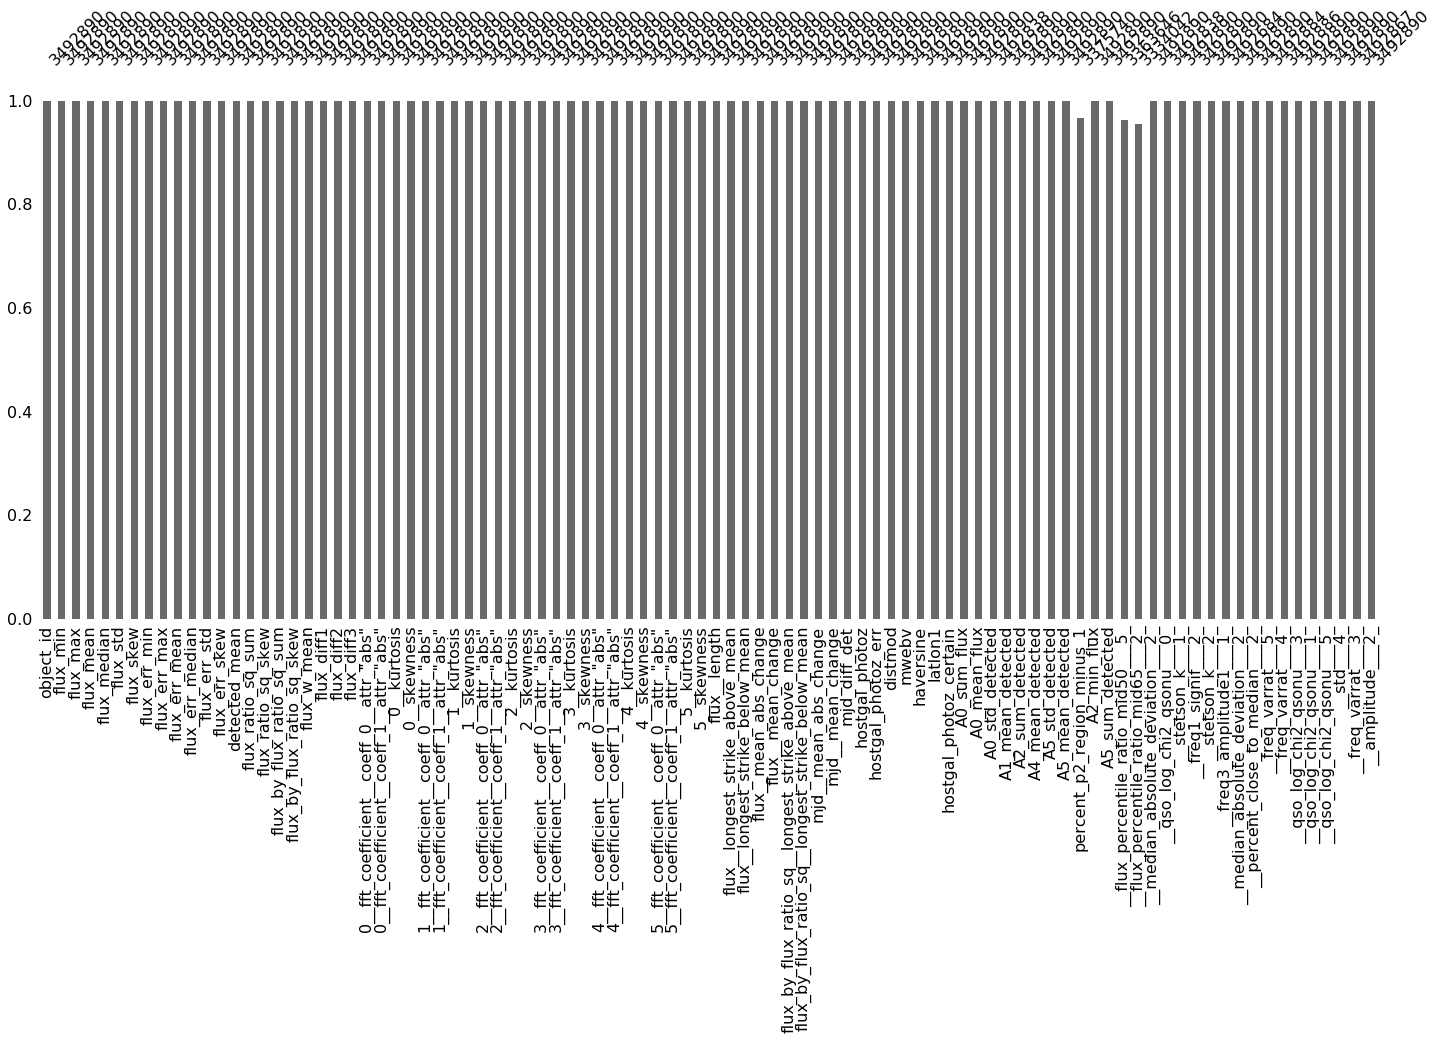

In [26]:
msno.bar(test_metadata_kaggle)

# 5) Removing duplicated_columns from train_metadata & test_metadata

In [27]:
temp = train_metadata_kaggle.copy()

In [28]:
y = temp['target']

In [29]:
del temp['target']

In [30]:
print(temp.shape)

(7848, 92)


In [31]:
temp.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,flux__length,flux__longest_strike_above_mean,flux__longest_strike_below_mean,flux__mean_abs_change,flux__mean_change,flux_by_flux_ratio_sq__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_below_mean,mjd__mean_abs_change,mjd__mean_change,mjd_diff_det,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,haversine,latlon1,hostgal_photoz_certain,A0_sum_flux,A0_mean_flux,A0_std_detected,A1_mean_detected,A2_sum_detected,A4_mean_detected,A5_std_detected,A5_mean_detected,percent_p2_region_minus_1,A2_min_flux,A5_sum_detected,__flux_percentile_ratio_mid50___5_,__flux_percentile_ratio_mid65___2_,__median_absolute_deviation___2_,__qso_log_chi2_qsonu___0_,__stetson_k___1_,__freq1_signif___2_,__stetson_k___2_,__freq3_amplitude1___1_,__median_absolute_deviation___2_,__percent_close_to_median___2_,__freq_varrat___5_,__freq_varrat___4_,__qso_log_chi2_qsonu___3_,__qso_log_chi2_qsonu___1_,__qso_log_chi2_qsonu___5_,__std___4_,__freq_varrat___3_,__amplitude___2_
0,615,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,-327.742307,1761.066406,-14.306331,-5.373326,205.036926,1628.427737,-1.475181,0.128917,22370.594834,2806.374162,-1.255123,0.415580,7780.500807,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,-1.548319,0.200096,2704.641265,2893.344217,-1.592820,0.125268,352.0,19.0,29.0,202.114067,1.999688,35.0,4.0,2.631898,2.631898,873.7903,0.0000,0.0000,NaN,0.017,0.319006,-1.528827,0.000000,-205.03693,-3.254554,0.3528,0.9653,57,0.9830,0.2854,0.9120,0.362,-682.000,52,5.562230e-26,6.719410e-20,368.12900,6.217890,1.091730,5.49891,1.053490,114.465000,368.12900,0.172414,0.401664,0.129578,9.16612,9.508750,7.344980,289.27700,0.110785,646.9220
1,713,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,-4.884564,29.506064,-20.730002,-6.040676,190.427851,299.586559,-1.014003,0.260052,57.109047,192.539229,-1.097170,-0.087865,44.477327,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182,350.0,50.0,73.0,2.935177,-0.050944,199.0,8.0,14.352571,14.352571,846.8017,1.6267,0.2552,45.4063,0.007,1.698939,3.258921,2.099614,-190.42786,-2.720398,0.3525,0.2678,15,0.0893,0.0000,0.0000,0.250,-10.070,0,2.119070e-02,8.243180e-02,5.10035,2.187190,1.066100,3.95669,1.088180,0.851103,5.10035,0.178571,0.369518,0.166179,2.79753,3.124810,0.659762,6.34953,0.111883,10.2985
2,730,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,25.373110,66.469870,29.315018,2.619697,3.461790,4.729538,0.474215,0.356910,7.334944,13.515895,0.976374,0.471342,124.845250,119.500254,5.131290,2.385066,168.280524,162.799417,7.125665,2.662075,219.74

# 9) Writing helpful functions

In [32]:
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [33]:
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}
oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

# 10 ) Defining hyperparameters

In [34]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()
lgb_params = {
'random_state':51,
'device': 'cpu', 
'objective': 'multiclass', 
'num_class': 14, 
'boosting_type': 'gbdt', 
'n_jobs': -1, 
'max_depth': 7, 
'n_estimators': 1000, 
'subsample_freq': 2, 
'subsample_for_bin': 5000, 
'min_data_per_group': 100, 
'max_cat_to_onehot': 4, 
'cat_l2': 1.0, 
'cat_smooth': 59.5, 
'max_cat_threshold': 32, 
'metric_freq': 10, 
'verbosity': -1, 
'metric': 'multi_logloss', 
'xgboost_dart_mode': False, 
'uniform_drop': False, 
'colsample_bytree': 0.5, 
'drop_rate': 0.173, 
'learning_rate': 0.0267, 
'max_drop': 5, 
'min_child_samples': 10, 
'min_child_weight': 100.0, 
'min_split_gain': 0.1, 
'num_leaves': 7, 
'reg_alpha': 0.1, 
'reg_lambda': 0.00023, 
'skip_drop': 0.44, 
'subsample': 0.75}

CPU times: user 1.54 ms, sys: 130 µs, total: 1.67 ms
Wall time: 1.58 ms


In [35]:
"""
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}
"""


'\n# Compute weights\nw = y.value_counts()\nweights = {i : np.sum(w) / w[i] for i in w.index}\n'

# 11) Training

In [36]:
%%time
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
    val_x, val_y = temp.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = temp.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.717911	training's wloss: 0.707354	valid_1's multi_logloss: 1.07781	valid_1's wloss: 0.895225
[200]	training's multi_logloss: 0.461688	training's wloss: 0.449632	valid_1's multi_logloss: 0.852615	valid_1's wloss: 0.699799
[300]	training's multi_logloss: 0.36019	training's wloss: 0.347907	valid_1's multi_logloss: 0.771768	valid_1's wloss: 0.649833
[400]	training's multi_logloss: 0.301135	training's wloss: 0.288825	valid_1's multi_logloss: 0.730135	valid_1's wloss: 0.633612
Early stopping, best iteration is:
[448]	training's multi_logloss: 0.279556	training's wloss: 0.267591	valid_1's multi_logloss: 0.7153	valid_1's wloss: 0.630673
0.6306725280126511
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.719617	training's wloss: 0.710544	valid_1's multi_logloss: 1.07737	valid_1's wloss: 0.880312
[200]	training's multi_logloss: 0.463763	training's wloss: 

In [37]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 93) (3492890, 92)


In [38]:
%%time
train_metadata_kaggle.to_csv('mydata_train_metadata.csv',index=False)
test_metadata_kaggle.to_csv('mydata_test_metadata.csv',index=False)

CPU times: user 6min 39s, sys: 4.79 s, total: 6min 43s
Wall time: 6min 44s
